In a previous post, we explored generating the grid-neighborhoods of an element in a NumPy array.  The punch line of that work was `grid_nD`, shown below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

%matplotlib inline

from numpy.lib.stride_tricks import as_strided

In [2]:
def grid_nD(arr):
    assert all(_len>2 for _len in arr.shape)
    
    nDims = len(arr.shape)
    newShape = [_len-2 for _len in arr.shape]
    newShape.extend([3] * nDims)
    
    newStrides = arr.strides + arr.strides
    return as_strided(arr, shape=newShape, strides=newStrides)

Using `grid_nD`, coding the game of life becomes really, really easy.  Given the neighborhood around a cell, we can simply make use of two lookup tables:  (1) the rules to use if the center cell is alive and (2) the rules to use if the center cell is dead.  Normally, the Game of Life is implemented with these rules encoded as `if-then-else` or `case` statements.  Instead, we're going to use `np.where` which allows us to specify an array of boolean values (true/false, 1/0, alive/dead) and then pick from a "true/1/alive" value or a "false/0/dead" value.  

We'll create a table of the living values and a table of the dead values in two separate NumPy arrays.  For a given number of neighbors, we can lookup the state of the center cell for the next time point.

Recall the rules for a currently living cell:

  * If I'm alive and I have fewer than two alive neighors, I die of loneliness.
  * If I'm alive and I have two or three alive neighbors, I live.
  * If I'm alive and I have more than three alive neighbors, I die of starvation.

And for a currently dead cell:

  * If I'm dead and I have three (exactly) live neighbors, I become alive by spontaneous combustion.

In [3]:
# index is number of neighbors alive
ruleOfLifeAlive = np.zeros(8+1, np.uint8)  # default all to dead
ruleOfLifeAlive[[2,3]] = 1 # alive stays alive <=> 2 or 3 neighbors
print "ruleOfLifeAlive:", ruleOfLifeAlive

ruleOfLifeDead = np.zeros(8+1, np.uint8)   # default all to dead
ruleOfLifeDead[3] = 1      # dead switches to living <=> 3 neighbors
print " ruleOfLifeDead:", ruleOfLifeDead

ruleOfLifeAlive: [0 0 1 1 0 0 0 0 0]
 ruleOfLifeDead: [0 0 0 1 0 0 0 0 0]


So, for example a live cell with three neighbors looks up `ruleOfLifeAlive[3]` which has the value `1`, so it stays living.  Another dead cell, with five living neighbors looks up `ruleOfLifeDead[5]` and we get the value `0`:  it stays dead.

### The Game of Life

We're now ready to implement the Game of Life.  We only pull one non-obvious trick.  We don't want to have a "special case" for the cells on the boarder:  we want to count the neighbors by summing up a neighborhood (which can do easily with our `grid_nD` and a NumPy `np.sum` call) and subtracting the center cell value.  We do that in line 25 below.  With a sequence of `axes`, `np.sum(array, axes)` adds up over multiple axes.  For a 2D array, it is the two inner-most axes that pop out from the `grid_nD` call.  We can count from inside-out with `-1, -2`.

To prevent the need for "special" (partial) neighborhoods around the boarder, we simply embed our Game of Life board inside of a slightly larger board with `0`s surrounding our main board.  NumPy is able to do this in a clever way that makes the inner (main) board a "view" into the outer board so we don't have to duplicate memory.

One other pure Python piece you may not have seen is the use of `slice`.  When we write `arr[1:3, 4:10]`, the `:` character tells the Python interpreter to create a `slice` object.  We can also manually create them.  For `1:3`, the slice call looks like `slice(1,3)`.  For `4:10`, the call looks like `slice(1,4)`.  These are very useful if you have to *programmatically* develop the slice (instead of typing in fixed values and/or a fixed *number of slices*).  If you are unsure of the use-case ofr this, consider what would happen if (1) in one run of a program, you needed 5 dimensions of slicing and (2) in another run of the program, you need only 3 dimensions of slicing.  And, extending that, you wanted that program to work in arbitrary dimensions.

In [4]:
def imshow_helper(board, sleepSeconds=0.5):
    ''' helper method to display a board for short time interval 
        being lazy and using the MATLAB style API '''
    plt.imshow(board, cmap="binary", interpolation="none")
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(sleepSeconds)
    
class GameOfLife(object):
    def __init__(self, board_size=(10,10)):
        full_size = tuple(i+2 for i in board_size)
        self.full = np.zeros(full_size, dtype=np.uint8)
        nd_slice = (slice(1, -1),) * len(board_size)
        # self.board = self.full[1:-1,1:-1,...] 
        self.board = self.full[nd_slice]
        self.ndims = len(self.board.shape)
        
    def run_board(self, N_ITERS = 10):
        imshow_helper(self.board)
        for i in range(N_ITERS):
            neighborhoods = grid_nD(self.full)
            # shape = (10,10) --> (-1, -2)
            sumOver = tuple(-(i+1) for i in xrange(self.ndims))
            neighborCt = np.sum(neighborhoods, sumOver) - self.board
            self.board[:] = np.where(self.board, 
                                     ruleOfLifeAlive[neighborCt], 
                                     ruleOfLifeDead[neighborCt])
            imshow_helper(self.board)

### One Quick Board

Here's one quick board with a square in the lower right.  First we look at the raw NumPy array (just the inner array, ignoring the outer array that stores the extra zeros)

In [5]:
gol = GameOfLife()
gol.board[5:8,5:8] = 1
print gol.board

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


And here's what that array looks like when we interpret it as an image:

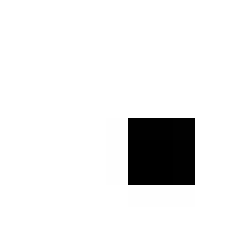

In [6]:
plt.imshow(gol.board, cmap="binary", interpolation="none")
plt.axis('off');

### And Some 2D Boards

Here are a few simple boards (starting configurations) and a few named boards from https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life#Examples_of_patterns

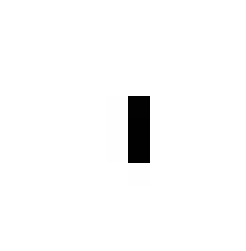

In [7]:
gol = GameOfLife()
gol.board[4:7, 5] = 1
gol.run_board(10)

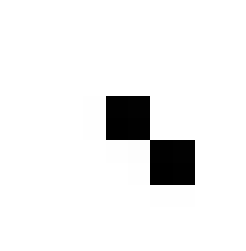

In [8]:
gol = GameOfLife()
gol.board[4:6, 4:6] = 1
gol.board[6:8, 6:8] = 1
gol.run_board(10)

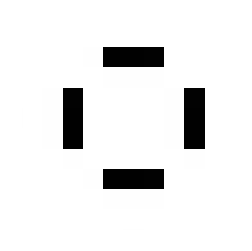

In [9]:
gol = GameOfLife((11,11))
gol.board[4,5]    = 1
gol.board[5, 4:7] = 1
gol.board[6,5] = 1
gol.run_board(10)

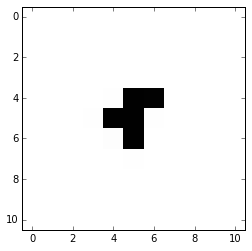

In [10]:
gol = GameOfLife((11,11))
gol.board[4,6]   = 1
gol.board[4:7,5] = 1
gol.board[5,4]   = 1
plt.imshow(gol.board, cmap="binary", interpolation="none")

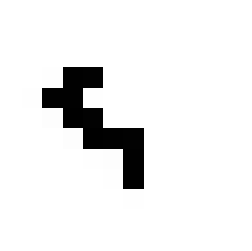

In [11]:
gol.run_board(10)

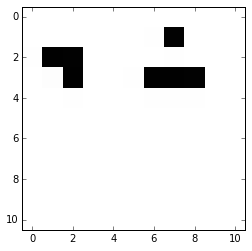

In [12]:
gol = GameOfLife((11,11))

gol.board[1,7] = 1
gol.board[2,1:3] = 1
gol.board[3,2] = 1
gol.board[3, 6:9] = 1

plt.imshow(gol.board, cmap="binary", interpolation="none")

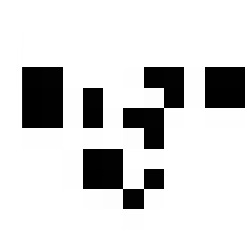

In [13]:
gol.run_board(50)

<h3>Additional Resources</h3>
<p>You can grab a [copy of this notebook](http://drsfenner.org/public/notebooks/GameOfLife.ipynb).</p>

<p>Even better, you can [view it using nbviewer](http://nbviewer.ipython.org/url/drsfenner.org/public/notebooks/GameOfLife.ipynb).</p>

<h3>License</h3>
<p>
Unless otherwise noted, the contents of this notebook are under the
following license. The code in the notebook should be considered part
of the text (i.e., licensed and treated as as follows).
</p>


<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecomm
ons.org/l/by-nc-sa/4.0/88x31.png" /></a><br/><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">DrsFenner.org Blog And Notebooks</span> by <a xmln
s:cc="http://creativecommons.org/ns#" href="drsfenner.org" property="cc:attributionName" rel="cc:attributionURL">Mark and Barbara Fenner</a> is licensed under a
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.<
br/>Permissions beyond the scope of this license may be available at <a xmlns:cc="http://creativecommons.org/ns#" href="drsfenner.org/blog/about-and-contacts" r
el="cc:morePermissions">drsfenner.org/blog/about-and-contacts</a>.
